# Practical Lab 2: Multivariate Linear Regression, Non-Parametric Models and Cross-Validation  
**Student Name:** Yogesh Kumar Gopal  
**ID:** 8996403
**Course:** CSCN8010


### Part 1: Data Preparation & EDA

In [119]:
# Import necessary libraries
from sklearn import datasets
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error

Get the Data

In [120]:
# Load diabetes dataset as DataFrame
diabetes = datasets.load_diabetes(as_frame=True)
df = diabetes.frame
df.head()


,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,135.0


**Objective:** Predict "disease progression one year after baseline" (target variable `y`) based on patient features (X).

EDA - Exploratory Data Analysis

In [121]:
# Statistics
df.describe()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
count,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,442.000000
mean,-2.511817e-19,1.230790e-17,-2.245564e-16,-4.797570e-17,-1.381499e-17,3.918434e-17,-5.777179e-18,-9.042540e-18,9.293722e-17,1.130318e-17,152.133484
std,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,77.093005
min,-1.072256e-01,-4.464164e-02,-9.027530e-02,-1.123988e-01,-1.267807e-01,-1.156131e-01,-1.023071e-01,-7.639450e-02,-1.260971e-01,-1.377672e-01,25.000000
25%,-3.729927e-02,-4.464164e-02,-3.422907e-02,-3.665608e-02,-3.424784e-02,-3.035840e-02,-3.511716e-02,-3.949338e-02,-3.324559e-02,-3.317903e-02,87.000000
50%,5.383060e-03,-4.464164e-02,-7.283766e-03,-5.670422e-03,-4.320866e-03,-3.819065e-03,-6.584468e-03,-2.592262e-03,-1.947171e-03,-1.077698e-03,140.500000
75%,3.807591e-02,5.068012e-02,3.124802e-02,3.564379e-02,2.835801e-02,2.984439e-02,2.931150e-02,3.430886e-02,3.243232e-02,2.791705e-02,211.500000
max,1.107267e-01,5.068012e-02,1.705552e-01,1.320436e-01,1.539137e-01,1.987880e-01,1.811791e-01,1.852344e-01,1.335973e-01,1.356118e-01,346.000000


<Axes: >

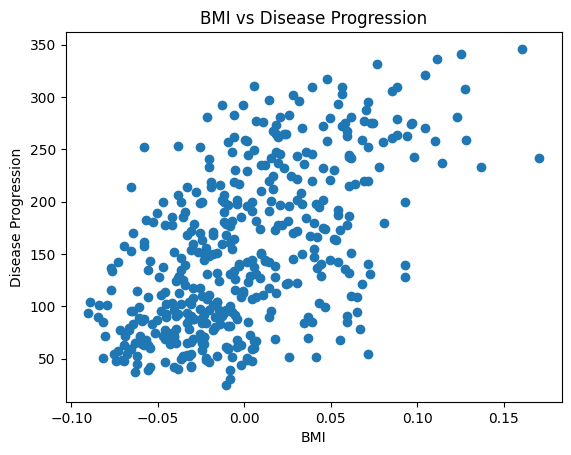

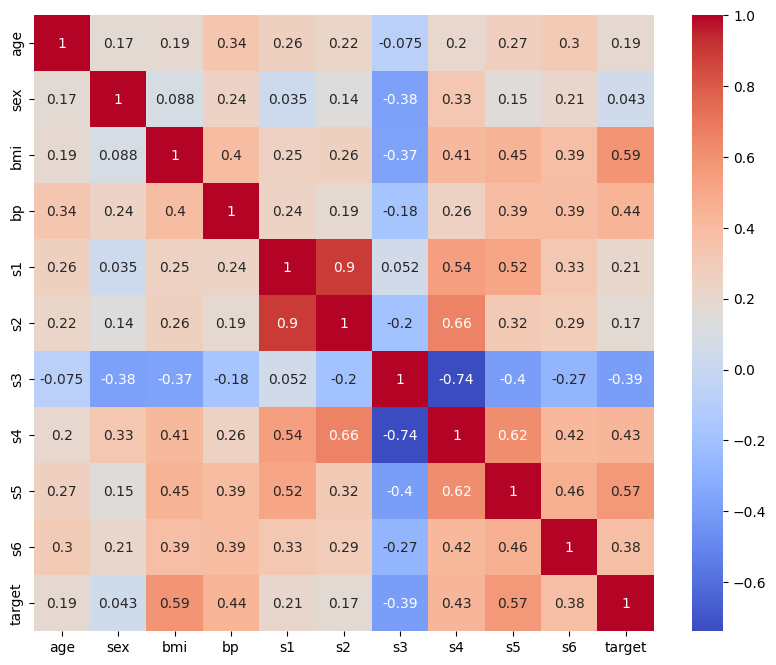

In [122]:
# Scatter plot for BMI vs Disease Progression
plt.scatter(df['bmi'], df['target'])
plt.xlabel('BMI')
plt.ylabel('Disease Progression')
plt.title('BMI vs Disease Progression')

# Correlation heatmap
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')


## Insights based on your EDA plots:

1. BMI is strongly correlated with disease progression:

    The scatter plot of BMI vs. target (disease progression) shows a clear positive trend, indicating that higher BMI values are associated with increased disease progression.

    The correlation matrix confirms this with a strong correlation coefficient of 0.59 between BMI and the target variable — one of the highest correlations observed.

2. Other significant features include S5 and BP:

    S5 shows a strong positive correlation (0.57) with the target.

    Blood Pressure (bp) also shows a moderate positive correlation (0.44), suggesting it’s a relevant predictor.

3. Feature distributions are standardized and mostly symmetric:

    Most features like age, bmi, bp, and s1–s6 are centered around 0 due to standardization, with fairly normal distributions.

    The target variable (disease progression) is right-skewed, indicating more cases with lower progression values and fewer extreme progression cases.

4. Some features are highly correlated with each other:

    S1 and S2 (both likely related to cholesterol or serum levels) have a very strong positive correlation (0.9), indicating multicollinearity.

    S3 and S4 are negatively correlated (-0.74), which may impact model interpretation.

Data Cleaning

In [123]:
df.isnull().sum()  # Check for missing values
##No missing values; no obvious outliers in EDA — no cleaning needed.

age       0
sex       0
bmi       0
bp        0
s1        0
s2        0
s3        0
s4        0
s5        0
s6        0
target    0
dtype: int64

Split Dataset

In [124]:
# Separate features and target
X = df.drop(columns='target')
y = df['target']

# Train (75%), validation (10%), test (15%)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.10/0.85, random_state=42)

print(f'Train: {X_train.shape[0]} samples')
print(f'Validation: {X_val.shape[0]} samples')
print(f'Test: {X_test.shape[0]} samples')


Train: 330 samples
Validation: 45 samples
Test: 67 samples


### Part 2: Univariate Polynomial Regression on BMI

Polynomial Regression Models (degrees 0 to 5)

In [125]:
# Only BMI feature
X_train_bmi = X_train[['bmi']]
X_val_bmi = X_val[['bmi']]
X_test_bmi = X_test[['bmi']]

results = []

for degree in range(6):
    poly = PolynomialFeatures(degree=degree)
    X_train_poly = poly.fit_transform(X_train_bmi)
    X_val_poly = poly.transform(X_val_bmi)
    
    model = LinearRegression()
    model.fit(X_train_poly, y_train)
    
    # Predictions
    y_train_pred = model.predict(X_train_poly)
    y_val_pred = model.predict(X_val_poly)
    
    # Metrics
    r2_train = r2_score(y_train, y_train_pred)
    r2_val = r2_score(y_val, y_val_pred)
    mae_val = mean_absolute_error(y_val, y_val_pred)
    mape_val = np.mean(np.abs((y_val - y_val_pred) / y_val)) * 100
    
    results.append({
        'Degree': degree,
        'R2Train': r2_train,
        'R2Val': r2_val,
        'MAEVal': mae_val,
        'MAPEVal': mape_val
    })
    
results_df = pd.DataFrame(results)
print(results_df)

print(results_df.columns.tolist())


   Degree   R2Train     R2Val     MAEVal    MAPEVal
0       0  0.000000 -0.000011  63.447475  58.793283
1       1  0.354240  0.449292  41.997581  40.444999
2       2  0.354771  0.449158  41.757683  40.309938
3       3  0.355002  0.447291  41.741042  40.258961
4       4  0.357983  0.449064  41.952846  40.240642
5       5  0.358910  0.453513  42.083400  40.340475
['Degree', 'R2Train', 'R2Val', 'MAEVal', 'MAPEVal']


### Identifing the best model


In [126]:
# Find the degree with the highest validation R²
best_deg = results_df.sort_values(by=['R2Val', 'MAEVal'], ascending=[False,True]).iloc[0]
best_degree_value = int(best_deg['Degree'])
print(f"Best model: Degree {best_degree_value}")

Best model: Degree 5


Based on highest R2 Val and lowest MAPE Val - Degree 5 looks good

Run on Test Set

In [ ]:
# Using the best degree
poly_best = PolynomialFeatures(degree=best_degree_value)
X_train_poly = poly_best.fit_transform(X_train_bmi)
X_test_poly = poly_best.transform(X_test_bmi)

model_best = LinearRegression()
model_best.fit(X_train_poly, y_train)

y_test_pred = model_best.predict(X_test_poly)

# Test metrics
r2_test = r2_score(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
mape_test = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100

print(f"R2 Test: {r2_test:.3f}, MAE Test: {mae_test:.2f}, MAPE Test: {mape_test:.2f}%")


R2 Test: 0.197, MAE Test: 54.55, MAPE Test: 47.88%


Plot Train, Val, Test vs Model

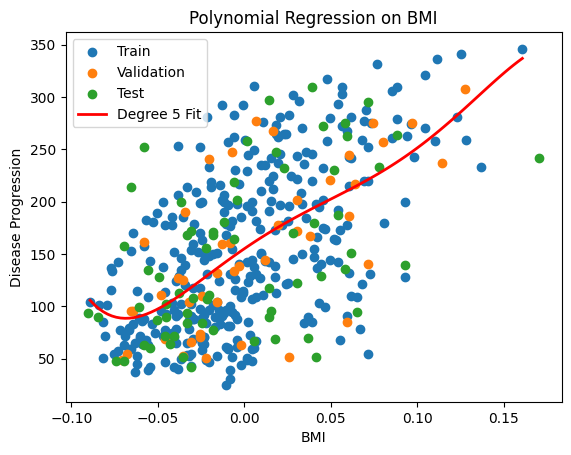

In [128]:
# Plot BMI vs Disease progression
plt.scatter(X_train_bmi, y_train, label='Train')
plt.scatter(X_val_bmi, y_val, label='Validation')
plt.scatter(X_test_bmi, y_test, label='Test')

# Line of best fit
bmi_range = np.linspace(X_train_bmi.min(), X_train_bmi.max(), 100).reshape(-1, 1)
bmi_range_df = pd.DataFrame(bmi_range, columns=['bmi'])

bmi_poly = poly_best.transform(bmi_range_df)
y_fit = model_best.predict(bmi_poly)
plt.plot(bmi_range, y_fit, color='red', linewidth=2, label=f'Degree {degree_best} Fit')

plt.xlabel('BMI')
plt.ylabel('Disease Progression')
plt.legend()
plt.title('Polynomial Regression on BMI')
plt.show()
